# Application of Projected nonlinear state-space (PNL-SS) model to van der Pol oscillator

In [1]:
%load_ext autoreload
%autoreload 2
import numpy
numpy.random.seed(0)
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# import gaussian-toolbox
import sys
import os

from jax.config import config
config.update("jax_enable_x64", True)
from jax import numpy as jnp


# To use the gaussian-toolbox, 
# go into the gaussian-toolbox folder, and type pip install .
# The maintained version of timeseries analysis using gaussian-toolbox is available at
# https://github.com/christiando/timeseries_models
from gaussian_toolbox import timeseries
from gaussian_toolbox.timeseries import state_model, observation_model, ssm

In [2]:
# Settings
# Noise
numpy.random.seed(0)
noise_level = .01 #original, 1.0#high noise,

# EM convergence criteria
CONV_CRIT = 1e-4 #1e-4
MAX_ITER = 100

# Van der Pol example

Application to the Van der Pol oscillator.

In [3]:
#import numpy
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

from scipy.integrate import solve_ivp
from scipy.stats import zscore

 Data consturction

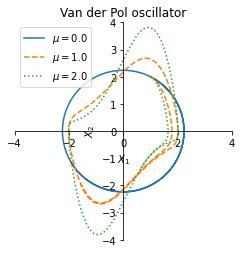

In [4]:
t = numpy.arange(0,10,0.01)

def vdp(t, z):
    x, y = z
    return [y, mu_param*(1 - x**2)*y - x]
    #return [mu_param * (x - 1./3.*x**3 - y), x / mu_param]

# Theoretical dynamics
#def vdp_plot():
mu_params = [0., 1., 2.]
styles = ["-", "--", ":"]
t = numpy.arange(0,10,0.01)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=r'$X_1$', ylabel=r'$X_2$')

for mu_param, style in zip(mu_params, styles):
    sol = solve_ivp(vdp, [0, 10], [1, 2], t_eval=t) #[1,0]
    plt.plot(sol.y[0], sol.y[1], style)

plt.legend([f"$\mu={m}$" for m in mu_params])

plt.title(r'Van der Pol oscillator')
plt.axis('square')

plt.xlim([-4,4])   
plt.ylim([-4,4]) 

#ax.grid(True)

# use set_position
ax.spines['top'].set_color('none')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')

#vdp_plot()
plt.savefig('fig/vanderpol_model.pdf', format='pdf')
plt.show()

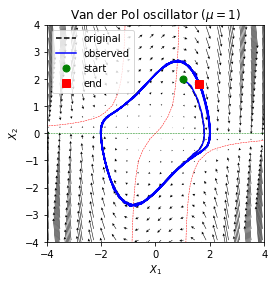

In [5]:
# Sample path 
# mu_param = 2.0
# sol = solve_ivp(vdp, [0, 10], [1, 2], t_eval=t)

# X = numpy.zeros((sol.y.shape[1],2))
# for i in range(sol.y.shape[1]):
#     X[i,:]=[sol.y[0,i],sol.y[1,i]]

def vanderpol(X, t):
    x = X[0]
    y = X[1]
    dxdt = mu_param * (x - 1./3.*x**3 - y)
    dydt = x / mu_param   
    return [dxdt, dydt]

def vanderpol2(X, t):
    x = X[0]
    y = X[1]
    dxdt = y
    dydt = mu_param*(1 - x**2)*y - x    
    return [dxdt, dydt]

mu_param = 1
t = numpy.linspace(0, 40*1, 250*1) #short trial
#t = numpy.linspace(0, 40*4, 250*4) # longer trial
state0  = [1, 2] #[1, 2]

states = odeint(vanderpol2, state0, t)
X = states

#X = zscore(X, axis=0)
X0 = X.copy()
X += noise_level * numpy.random.randn(*X.shape)

# Draw an example path
fig = plt.figure()
ax = fig.add_subplot(111, xlabel=r'$X_1$', ylabel=r'$X_2$')

# Draw vector field
def draw_vectorfield_true(ns=30, scale=200, headwidth=5):
    x = numpy.linspace(-6, 6, ns)
    y = numpy.linspace(-6, 6, ns)
    XX, YY = numpy.meshgrid(x,y)

    z1 = numpy.vstack([XX.flatten(), YY.flatten()]).T

    dz = numpy.zeros((ns*ns,2))
    for i in range(ns*ns):
        dz[i,:] = vanderpol2(z1[i,:],0)

    dz[:,0].reshape(ns,ns)
    plt.quiver(z1[:,0],z1[:,1],dz[:,0],dz[:,1], scale=scale, headwidth=headwidth)

    # Draw nullclines
    plt.contour(XX, YY, dz[:,0].reshape(ns,ns), levels=[0], colors="green", linestyles='--', linewidths=.5)
    plt.contour(XX, YY, dz[:,1].reshape(ns,ns), levels=[0], colors="red", linestyles='--', linewidths=.5)

    # Plot sample path
    plt.plot(X0[:,0],X0[:,1],'k--')
    plt.plot(X[:,0],X[:,1],'b')
    plt.plot(X[0,0],X[0,1],'g.', markersize=14)
    plt.plot(X[-1,0],X[-1,1],'rs', markersize=8)

    # Legend
    plt.legend(['original','observed','start','end'])
    plt.title(r'Van der Pol oscillator ($\mu=%i$)' %mu_param)
    plt.axis('square')

    plt.xlim([-4,4])   
    plt.ylim([-4,4]) 
    
    plt.xlabel(r'$X_1$')
    plt.ylabel(r'$X_2$')

draw_vectorfield_true()
plt.show()

# Application of linear model

In [6]:
Dx = 2
Dz = 2 #5
sm = state_model.LinearStateModel(Dz)
om = observation_model.LinearObservationModel(Dx, Dz)

#om.pca_init(X)

Iteration 10 - Log likelihood=-536.0
Iteration 20 - Log likelihood=-520.2
Iteration 30 - Log likelihood=-513.7
Iteration 40 - Log likelihood=-510.1
Iteration 50 - Log likelihood=-508.0
Iteration 60 - Log likelihood=-506.8
EM did converge.


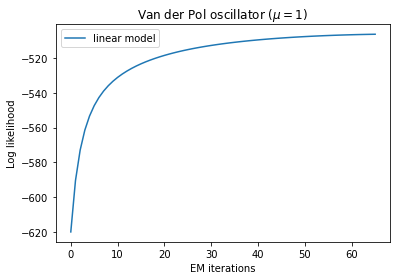

In [7]:
ssm_em_lin = ssm.StateSpaceModel(jnp.array(X), observation_model=om, state_model=sm, max_iter=MAX_ITER, conv_crit=CONV_CRIT)
ssm_em_lin.fit()
plt.plot(ssm_em_lin.llk_list[1:])
plt.xlabel('EM iterations')
plt.ylabel('Log likelihood')
plt.legend(['linear model','nonlinear model'])
plt.title(r'Van der Pol oscillator ($\mu=%i$)' %mu_param)
plt.show()

## Linear model: smoothing

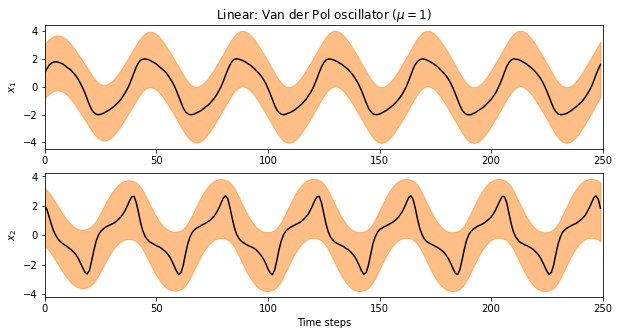

In [8]:
p_x = ssm_em_lin.compute_data_density()

plt.figure(figsize=(10,5))
for ix in range(Dx):
    plt.subplot(Dx,1,ix+1)
    if ix == 0:
        plt.title(r'Linear: Van der Pol oscillator ($\mu=%i$)' %mu_param)   
    x_min = p_x.mu[:,ix] - 1.96 * numpy.sqrt(p_x.Sigma[:,ix,ix]) #1.68
    x_max = p_x.mu[:,ix] + 1.96 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    plt.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    plt.plot(X[:,ix],'k')
    plt.ylabel(r'$x_%d$' %(ix+1))
    plt.xlim([0,X.shape[0]])
plt.xlabel('Time steps')
plt.show()

## Linear model: prediction

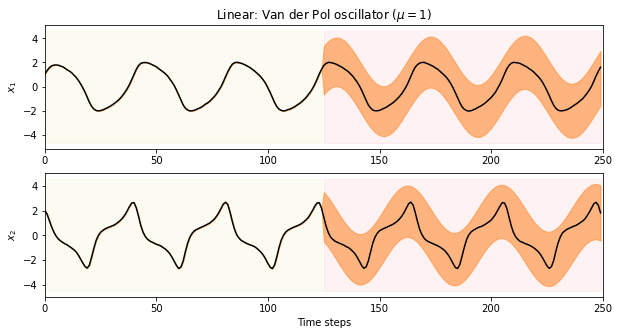

In [9]:
X_test0 = numpy.copy(X[:250,:])
idx_pred = range(int(X_test0.shape[0]*2/4),int(X_test0.shape[0]))
X_test = numpy.copy(X_test0)
X_test[idx_pred,:] = numpy.nan
filter_test, mu_lin, std_lin = ssm_em_lin.predict_nans(X_test)

def plot_prediction_linear(ax_list):   
    for ix in range(Dx):
        ax = ax_list[ix]#plt.subplot(Dx,1,ix+1)
        # Title
        if ix == 0:
            ax.set_title(r'Linear: Van der Pol oscillator ($\mu=%i$)' %mu_param )  
        # Draw the credible intervals of prediction
        x_min = mu_lin[:,ix] - 1.96 * std_lin[:,ix]
        x_max = mu_lin[:,ix] + 1.96 * std_lin[:,ix]
        ax.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
        # Draw filtering, prediction background
        ymin, ymax = ax.get_ylim()
        ax.fill_between(range(0,idx_pred[1]-1), ymin, ymax, color='y', alpha=.05)
        ax.fill_between(idx_pred, ymin, ymax, color='r', alpha=.05)
        # Draw the data
        ax.plot(X_test0[:,ix],'k')
        # Labels
        ax.set_ylabel(r'$x_%d$' %(ix+1))
        ax.set_xlim([0,X_test.shape[0]])
    ax.set_xlabel('Time steps')
  
fig = plt.figure(figsize=(10,5)) 
ax_list = [fig.add_subplot(Dx,1,1), fig.add_subplot(Dx,1,2)]
plot_prediction_linear(ax_list)
plt.show()


## Vector field

(2, 2)


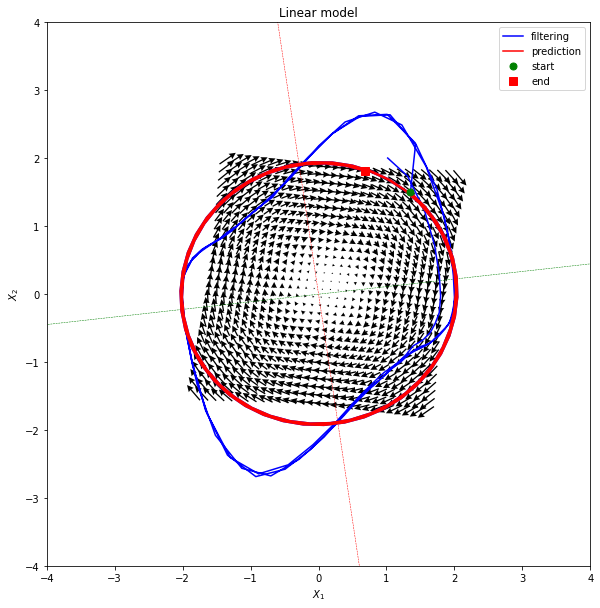

In [10]:
def draw_vectorfield_linear(ns=30, scale=10, headwidth=5):
    # Draw vetor field
    x = numpy.linspace(-6, 6, ns)
    y = numpy.linspace(-6, 6, ns)
    XX, YY = numpy.meshgrid(x,y)

    z1 = numpy.vstack([XX.flatten(), YY.flatten()]).T
    print(ssm_em_lin.sm.A.shape)
    z2 = numpy.dot(ssm_em_lin.sm.A, z1.T).T
    dz = z2 - z1

    z1 = numpy.dot(ssm_em_lin.om.C, z1.T).T + ssm_em_lin.om.d
    z2 = numpy.dot(ssm_em_lin.om.C, z2.T).T + ssm_em_lin.om.d
    dz = z2 - z1

    plt.quiver(z1[:,0],z1[:,1],dz[:,0],dz[:,1], scale=scale, headwidth=headwidth)

    # Draw nullclines
    ns = 80
    x = numpy.linspace(-6, 6, ns)
    y = numpy.linspace(-6, 6, ns)
    XX, YY = numpy.meshgrid(x,y)

    z1 = numpy.vstack([XX.flatten(), YY.flatten()]).T
    z2 = numpy.dot(ssm_em_lin.sm.A,z1.T).T
    dz = z2 - z1

    z1 = numpy.dot(ssm_em_lin.om.C, z1.T).T + ssm_em_lin.om.d
    z2 = numpy.dot(ssm_em_lin.om.C, z2.T).T + ssm_em_lin.om.d
    dz = z2 - z1

    plt.contour(XX, YY, dz[:,0].reshape(ns,ns), levels=[0], colors="green", linestyles='--', linewidths=.5)
    plt.contour(XX, YY, dz[:,1].reshape(ns,ns), levels=[0], colors="red", linestyles='--', linewidths=.5)

    # Draw prediction
    plt.plot(mu_lin[:,0],mu_lin[:,1],'b-')
    plt.plot(mu_lin[idx_pred,0],mu_lin[idx_pred,1],'r-')

    plt.plot(mu_lin[idx_pred[0],0],mu_lin[idx_pred[0],1],'g.', markersize=14)
    plt.plot(mu_lin[-1,0],mu_lin[-1,1],'rs', markersize=8)

    # Legend
    plt.legend(['filtering','prediction','start','end'])
    plt.title(r'Linear model')
    
    plt.axis('square')
    plt.xlim([-4,4])   
    plt.ylim([-4,4]) 
    
    plt.xlabel(r'$X_1$')
    plt.ylabel(r'$X_2$')

fig = plt.figure(figsize=(10,10))
draw_vectorfield_linear()
plt.show()

# Application of PLN-SS model

In [11]:
Dz = 2
Dk = 15 #9#9
sm = state_model.LSEMStateModel(Dz, Dk, noise_z=1.0)
om = observation_model.LinearObservationModel(Dx, Dz)

#om.pca_init(X)

ssm_emd = ssm.StateSpaceModel(jnp.array(X), observation_model=om, state_model=sm, max_iter=MAX_ITER, conv_crit=CONV_CRIT)
ssm_emd.fit()

Iteration 10 - Log likelihood=-529.9
Iteration 20 - Log likelihood=-506.9
Iteration 30 - Log likelihood=-499.0
Iteration 40 - Log likelihood=-494.5
Iteration 50 - Log likelihood=-491.6
Iteration 60 - Log likelihood=-489.2
Iteration 70 - Log likelihood=-487.8
Iteration 80 - Log likelihood=-486.7
Iteration 90 - Log likelihood=-486.1
EM did converge.


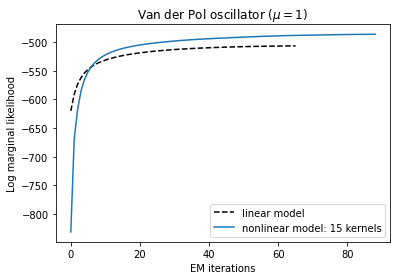

In [12]:
def plot_logmarginal_likelihood():
    plt.plot(ssm_em_lin.llk_list[1:],'k--')
    plt.plot(ssm_emd.llk_list[1:])
    plt.xlabel('EM iterations')
    plt.ylabel('Log marginal likelihood')
    plt.legend(['linear model','nonlinear model: %i kernels' %Dk])
    plt.title(r'Van der Pol oscillator ($\mu=%i$)' %mu_param)

plot_logmarginal_likelihood()
plt.savefig('fig/vanderpol_likelihood.pdf', format='pdf')
plt.show()

## Plot learned parameters

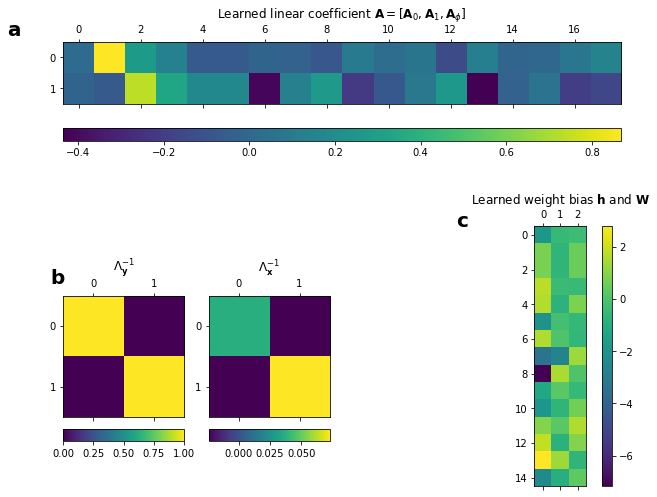

In [13]:
from copy import deepcopy
#sm_copy = deepcopy(ssm_emd.sm)
sm_copy = ssm_emd.sm
# sm_copy.W[:,1:] = 0
# sm_copy.W[:,1] = 1 
# sm_copy.update_state_density()

# num_plot_points = 100
# z_mat = numpy.zeros((num_plot_points, sm_copy.Dz))
# z_range = numpy.linspace(-3,3,num_plot_points)
# z_mat[:,0] = z_range
# func_1D = sm_copy.state_density.get_conditional_mu(jnp.array(z_mat))


# Figure construction
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import string

fig = plt.figure(figsize=(10,10))

gs = GridSpec(4, 4, figure=fig)
ax1 = fig.add_subplot(gs[:2,:4])
ax2 = fig.add_subplot(gs[2:, 0])
ax3 = fig.add_subplot(gs[2:, 1])
ax4 = fig.add_subplot(gs[2:,3:])

# Plot linear coefficients
# self.Dphi = self.Dk + self.Dz
# self.A = 0 * numpy.random.randn(self.Dz, self.Dphi)
ax = ax1
#ax = fig.add_subplot(312, xlabel=r'1 bias, %i linear' %Dz + ' and %i nonliner kernels' %Dk, ylabel=r'%i latent states' %Dz)
im = ax.matshow(numpy.hstack((ssm_emd.sm.b.reshape(Dz,1), ssm_emd.sm.A)) )
#plt.colorbar(tmp, orientation="horizontal", pad=0.1)
#fig.colorbar(tmp, fraction=0.046, pad=0.04)
axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="20%",  # height : 50%
                   loc='center',
                   bbox_to_anchor=(0.0, -1., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im, cax=axins, orientation="horizontal")
ax.set_title(r'Learned linear coefficient $\mathbf{A}=[\mathbf{A}_0,\mathbf{A}_1,\mathbf{A}_\phi]$')
ax.text(-0.1, 1.1, string.ascii_lowercase[0], transform=ax.transAxes, 
            size=20, weight='bold')


# Show noise covariance matrices
ax = ax2
ax.set_title(r'$\Lambda_{\mathbf{y}}^{-1}$') #Qy
im = ax.matshow(ssm_emd.om.Qx)
axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="10%",  # height : 50%
                   loc='upper center',
                   bbox_to_anchor=(0.0, -1.1, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im, cax=axins, orientation="horizontal")
ax.text(-0.1, 1.1, string.ascii_lowercase[1], transform=ax.transAxes, 
            size=20, weight='bold')

ax = ax3
ax.set_title(r'$\Lambda_{\mathbf{x}}^{-1}$') #Qx
im = ax.matshow(ssm_emd.sm.Qz)
axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="10%",  # height : 50%
                   loc='upper center',
                   bbox_to_anchor=(0.0, -1.1, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im, cax=axins, orientation="horizontal")
#fig.colorbar(tmp)


# Plot weight matrix
# :param W: numpy.ndarray [Dphi, Dx + 1]
#     Parameters for linear mapping in the nonlinear functions
ax = ax4
im = ax.matshow(ssm_emd.sm.W)
axins = inset_axes(ax,
                   width="20%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='center',
                   bbox_to_anchor=(.9, 0.0, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im, cax=axins)
ax.set_title(r'Learned weight bias $\mathbf{h}$ and $\mathbf{W}$')
ax.text(-1.5, 1.0, string.ascii_lowercase[2], transform=ax.transAxes, 
            size=20, weight='bold')

fig.savefig('fig/vanderpol_learnedparams.pdf', format='pdf')
#plt.show()

## PNL-SS model: smoothing

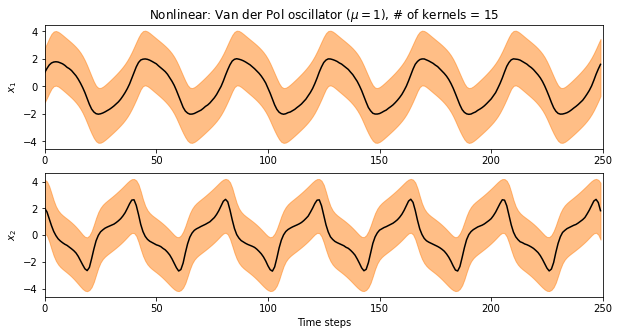

In [14]:
p_x = ssm_emd.compute_data_density()
plt.figure(figsize=(10,5))
for ix in range(Dx):
    plt.subplot(Dx,1,ix+1)
    if ix == 0:
        plt.title(r'Nonlinear: Van der Pol oscillator ($\mu=%i$)' %mu_param + ', # of kernels = %i' %Dk)   
    x_min = p_x.mu[:,ix] - 1.96 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    x_max = p_x.mu[:,ix] + 1.96 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    plt.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    plt.plot(X[:,ix],'k')
    plt.ylabel(r'$x_%d$' %(ix+1))
    plt.xlim([0,X.shape[0]])
plt.xlabel('Time steps')
plt.show()

## PNL-SS model: prediction

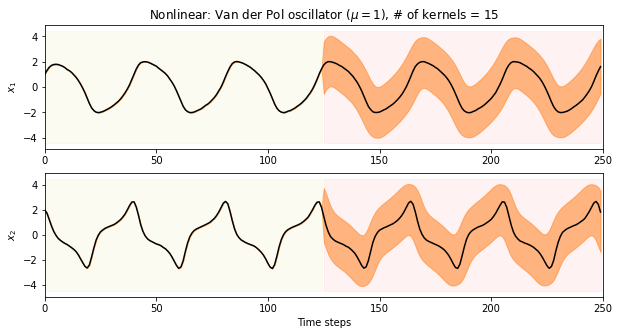

In [15]:
X_test0 = numpy.copy(X[:250,:])
idx_pred = range(int(X_test0.shape[0]*2/4),int(X_test0.shape[0]))
X_test = numpy.copy(X_test0)
X_test[idx_pred,:] = numpy.nan
filter_test, mu, std = ssm_emd.predict_nans(jnp.array(X_test), smoothed=False)

def plot_prediction_nonlinear(ax_list):
    for ix in range(Dx):
        ax = ax_list[ix]#plt.subplot(Dx,1,ix+1)
        # Title
        if ix == 0:
            ax.set_title(r'Nonlinear: Van der Pol oscillator ($\mu=%i$)' %mu_param + ', # of kernels = %i' %Dk)  
        # Draw the credible intervals of prediction
        x_min = mu[:,ix] - 1.96 * std[:,ix]
        x_max = mu[:,ix] + 1.96 * std[:,ix]
        ax.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
        # Draw filtering, prediction background
        ymin, ymax = ax.get_ylim()
        ax.fill_between(range(0,idx_pred[1]-1), ymin, ymax, color='y', alpha=.05)
        ax.fill_between(idx_pred, ymin, ymax, color='r', alpha=.05)
        # Draw the data
        ax.plot(X_test0[:,ix],'k')
        # Labels
        ax.set_ylabel(r'$x_%d$' %(ix+1))
        ax.set_xlim([0,X_test0.shape[0]])

    ax.set_xlabel('Time steps')
        
fig = plt.figure(figsize=(10,5)) 
ax_list = [fig.add_subplot(Dx,1,1), fig.add_subplot(Dx,1,2)]
plot_prediction_nonlinear(ax_list)
plt.show()

## Vector field

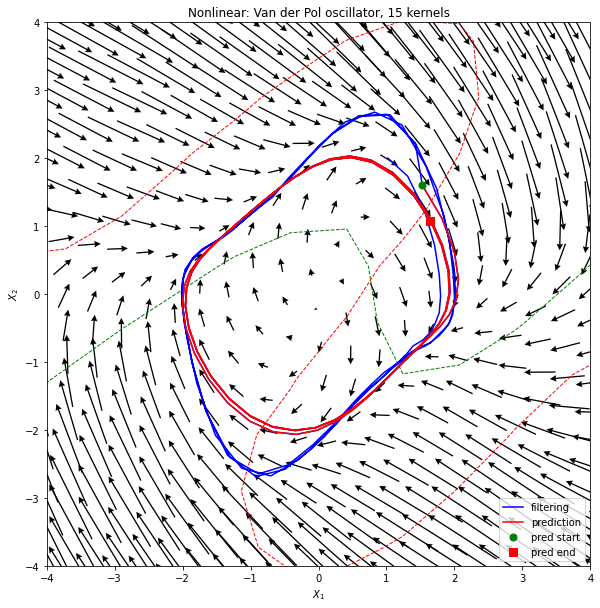

[1.52775142 1.60100365]


In [16]:
def draw_vectorfield_nonlinear(ns=30, scale=10, headwidth=5):
    # Draw vetor field
    x = numpy.linspace(-12, 12, ns)
    y = x
    XX, YY = numpy.meshgrid(x,y)

    z1 = numpy.vstack([XX.flatten(), YY.flatten()]).T
    z2 = ssm_emd.sm.state_density.get_conditional_mu(jnp.array(z1))
    #dz = z2 - z1

    z1 = numpy.dot(ssm_emd.om.C, z1.T).T + ssm_emd.om.d
    z2 = numpy.dot(ssm_emd.om.C, z2.T).T + ssm_emd.om.d
    dz = z2 - z1

    plt.quiver(z1[:,0], z1[:,1], dz[:,0], dz[:,1], scale=scale, headwidth=headwidth)

    # Draw nullclines
    #ns = 60
    x = numpy.linspace(-12, 12, ns)
    y = x
    XX, YY = numpy.meshgrid(x,y)

    z1 = numpy.vstack([XX.flatten(), YY.flatten()]).T
    z2 = ssm_emd.sm.state_density.get_conditional_mu(jnp.array(z1))
    #dz = z2 - z1

    z1 = numpy.dot(ssm_emd.om.C, z1.T).T + ssm_emd.om.d
    z2 = numpy.dot(ssm_emd.om.C, z2.T).T + ssm_emd.om.d
    dz = z2 - z1

    plt.contour(XX, YY, dz[:,0].reshape(ns,ns), levels=[0], colors="green", linestyles='--', linewidths=1)
    plt.contour(XX, YY, dz[:,1].reshape(ns,ns), levels=[0], colors="red", linestyles='--', linewidths=1)

    # Draw prediction
    plt.plot(mu[:,0],mu[:,1],'b-')
    plt.plot(mu[idx_pred,0],mu[idx_pred,1],'r-')

    #plt.plot(mu[0,0],mu[0,1],'g.', markersize=14)
    plt.plot(mu[idx_pred[0],0],mu[idx_pred[0],1],'g.', markersize=14)
    plt.plot(mu[-1,0],mu[-1,1],'rs', markersize=8)

    # Legend
    plt.legend(['filtering','prediction','pred start','pred end'])
    plt.title(r'Nonlinear: Van der Pol oscillator, %i kernels' %Dk)   

    plt.axis('square')
    # plt.xlim([-3,3])   
    # plt.ylim([-3,3]) 
    plt.xlim([-4,4])   
    plt.ylim([-4,4]) 
    
    plt.xlabel(r'$X_1$')
    plt.ylabel(r'$X_2$')

fig = plt.figure(figsize=(10,10))
draw_vectorfield_nonlinear()
plt.show()
print(mu[idx_pred[0]])

## Predicting by ODE solver

[1.52775142 1.60100365]


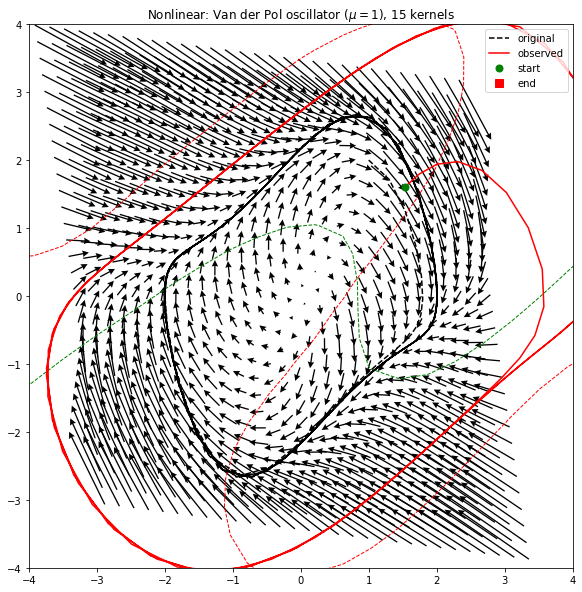

In [17]:
fig = plt.figure(figsize=(10,10))

def learned_dynamics(X, t):
    x = X[0]
    y = X[1]
    z1 = numpy.array([[x,y]])
    z2 = ssm_emd.sm.state_density.get_conditional_mu(z1)
    dz = 1*(z2 - z1)
    dxdt = dz[0,0]
    dydt = dz[0,1]
    return [dxdt, dydt]

mu_param = 1
#t = numpy.linspace(0, 40*1, 250*1) #short trial
ti = numpy.linspace(20, 40*1, 125)
state0 = mu[idx_pred[0]]
#states = odeint(learned_dynamics, state0, ti)

ms = 125#250
states = numpy.zeros((ms,2))
states[0,:] = state0
for i in range(1,ms):
    tmp = learned_dynamics(states[i-1,:],i)
    states[i,:] = states[i-1,:] + 1*numpy.array(tmp)

X_forward = states


# Draw vetor field
ns = 30
x = numpy.linspace(-6, 6, ns)
y = x
XX, YY = numpy.meshgrid(x,y)

z1 = numpy.vstack([XX.flatten(), YY.flatten()]).T
z2 = ssm_emd.sm.state_density.get_conditional_mu(z1)
#dz = z2 - z1

z1 = numpy.dot(ssm_emd.om.C, z1.T).T + ssm_emd.om.d
z2 = numpy.dot(ssm_emd.om.C, z2.T).T + ssm_emd.om.d
dz = z2 - z1

plt.quiver(z1[:,0], z1[:,1], dz[:,0], dz[:,1], scale=10, headwidth=5)

plt.contour(XX, YY, dz[:,0].reshape(ns,ns), levels=[0], colors="green", linestyles='--', linewidths=1)
plt.contour(XX, YY, dz[:,1].reshape(ns,ns), levels=[0], colors="red", linestyles='--', linewidths=1)


# Plot sample path
plt.plot(X0[:,0],X0[:,1],'k--')
plt.plot(X_forward[:,0],X_forward[:,1],'r')
plt.plot(X_forward[0,0],X_forward[0,1],'g.', markersize=14)
plt.plot(X_forward[-1,0],X_forward[-1,1],'rs', markersize=8)

# Legend
plt.legend(['original','observed','start','end'])
plt.title(r'Nonlinear: Van der Pol oscillator ($\mu=%i$)' %mu_param + ', %i kernels' %Dk)
plt.axis('square')

plt.xlim([-4,4])   
plt.ylim([-4,4]) 

print(state0)
plt.show()

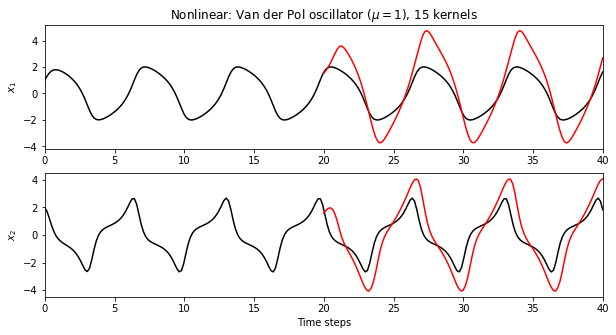

In [18]:
plt.figure(figsize=(10,5))

for ix in range(Dx):
    ax = plt.subplot(Dx,1,ix+1)
    # Title
    if ix == 0:
        plt.title(r'Nonlinear: Van der Pol oscillator ($\mu=%i$)' %mu_param + ', %i kernels' %Dk)
    # Draw the data
    plt.plot(t,X0[:,ix],'k')
    # Draw ODE solver
    plt.plot(ti,X_forward[:,ix],'r')
    # Labels
    plt.ylabel(r'$x_%d$' %(ix+1))
    plt.xlim([0,max(t)])

plt.xlabel('Time steps')
plt.show()

## Prediction assuming no noise

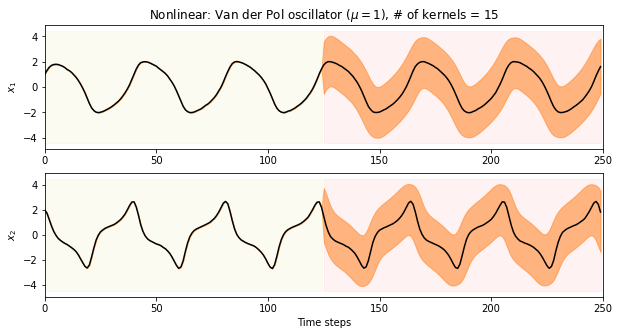

In [19]:
from copy import deepcopy
# ssm_emd_copy = deepcopy(ssm_emd)
ssm_emd_copy = ssm_emd

#ssm_emd_copy.om.Qx = 0.001*numpy.eye(ssm_emd_copy.Dx) #0.00001
ssm_emd_copy.om.update_observation_density()
#ssm_emd_copy.sm.Qz = 0.001*numpy.eye(ssm_emd_copy.Dz)
ssm_emd_copy.sm.update_state_density()

X_test0 = numpy.copy(X[:250,:])
idx_pred = range(int(X_test0.shape[0]*2/4),int(X_test0.shape[0]))
X_test = numpy.copy(X_test0)
X_test[idx_pred,:] = numpy.nan
filter_test, mu, std = ssm_emd_copy.predict_nans(X_test, smoothed=False)

plt.figure(figsize=(10,5))
for ix in range(Dx):
    ax = plt.subplot(Dx,1,ix+1)
    # Title
    if ix == 0:
        plt.title(r'Nonlinear: Van der Pol oscillator ($\mu=%i$)' %mu_param + ', # of kernels = %i' %Dk)
    # Draw the credible intervals of prediction
    x_min = mu[:,ix] - 1.96 * std[:,ix]
    x_max = mu[:,ix] + 1.96 * std[:,ix]
    #plt.plot(idx_pred, mu[idx_pred,ix], color='b')
    plt.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    
    # Draw filtering, prediction background
    ymin, ymax = ax.get_ylim()
    plt.fill_between(range(0,idx_pred[1]-1), ymin, ymax, color='y', alpha=.05)
    plt.fill_between(idx_pred, ymin, ymax, color='r', alpha=.05)
    # Draw the data
    plt.plot(X_test0[:,ix],'k')
    
    # Labels
    plt.ylabel(r'$x_%d$' %(ix+1))
    plt.xlim([0,X_test0.shape[0]])

plt.xlabel('Time steps')
plt.show()

## Prediction by sampling

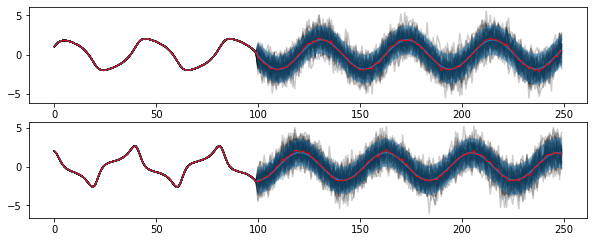

In [20]:
from matplotlib import pyplot

fully_observed_till = 100
num_samples = 50
p_z_fo, mu_x_fo, std_x_fo = ssm_em_lin.predict(jnp.array(X_test[:fully_observed_till]), observed_dims=jnp.arange(X_test.shape[1]))
p0 = p_z_fo.slice(jnp.array([-1]))
p_z_predict, mu_x_predict, std_x_predict = ssm_em_lin.predict(jnp.array(X_test[fully_observed_till:]), p0=p0)
sample_z_predict, sample_x_predict = ssm_em_lin.sample_trajectory(jnp.array(X_test[fully_observed_till:]), p0=p0, num_samples=num_samples)

mu_predict = jnp.concatenate([X_test[:fully_observed_till], mu_x_predict])
sample_x = jnp.empty((X_test.shape[0], num_samples, Dx))
sample_x = sample_x.at[:fully_observed_till].set(X_test[:fully_observed_till,None])
sample_x = sample_x.at[fully_observed_till:].set(sample_x_predict)
std_predict = jnp.concatenate([jnp.zeros(X[:fully_observed_till].shape), std_x_predict])

pyplot.figure(figsize=(10,6))
for dx in range(Dx):
    pyplot.subplot(3,1,dx+1)
    pyplot.plot(mu_predict[:,dx], zorder=9)
    pyplot.plot(sample_x[:,:,dx], 'k', alpha=.2)
    pyplot.fill_between(range(mu_predict.shape[0]), mu_predict[:,dx] - 1.68*std_predict[:,dx], mu_predict[:,dx] + 1.68*std_predict[:,dx], alpha=.5, zorder=9)
    pyplot.plot(jnp.mean(sample_x[:,:,dx],axis=1), 'r', alpha=1, lw=1, zorder=9)
    

## Summary Figures

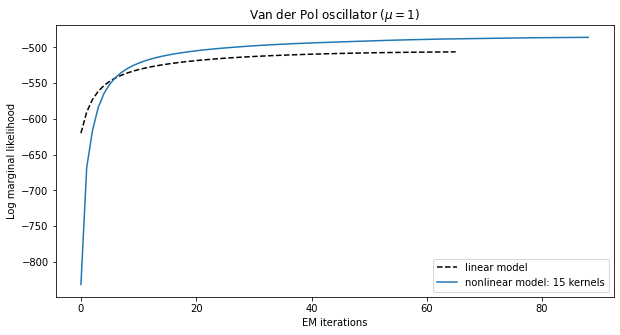

In [21]:
fig = plt.figure(figsize=(10,5))

plot_logmarginal_likelihood()
ax.text(-0.1, 1.1, string.ascii_lowercase[1], transform=ax.transAxes, size=20, weight='bold')
plt.show()

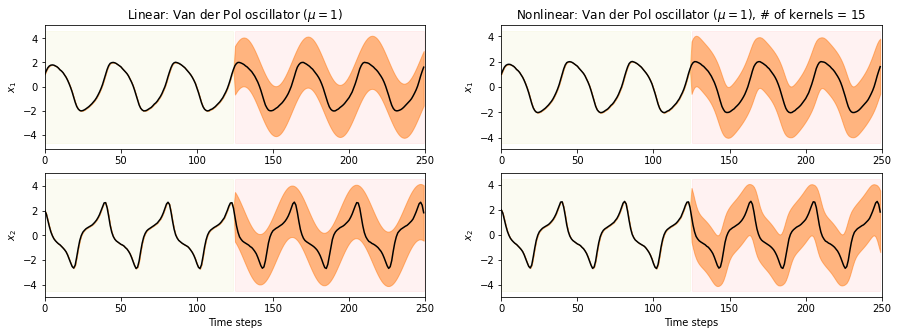

In [22]:
fig = plt.figure(figsize=(15,5)) 
ax_list = [fig.add_subplot(Dx,2,1), fig.add_subplot(Dx,2,3)]
plot_prediction_linear(ax_list)

ax_list = [fig.add_subplot(Dx,2,2), fig.add_subplot(Dx,2,4)]
plot_prediction_nonlinear(ax_list)

plt.savefig('fig/vanderpol_prediction.pdf', format='pdf')
plt.show()

(2, 2)


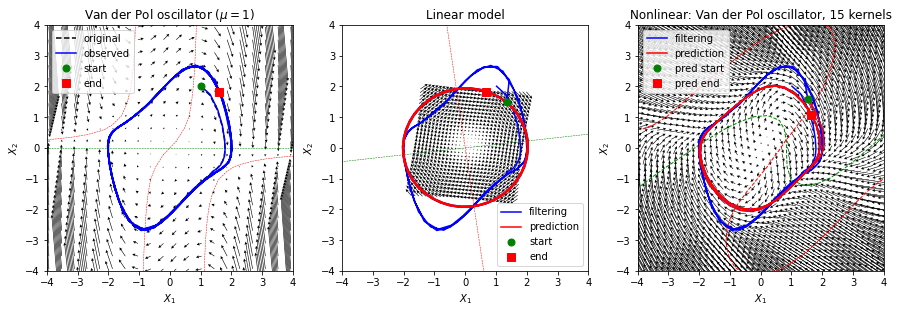

In [23]:
#Vector field
fig = plt.figure(figsize=(15,5))
ns = 30
scale = 10
headwidth = 5
ax = fig.add_subplot(1,3,1)
draw_vectorfield_true(ns=30, scale=150, headwidth=5)

ax = fig.add_subplot(1,3,2)
draw_vectorfield_linear(ns=ns,scale=scale,headwidth=headwidth)

ax = fig.add_subplot(1,3,3)
draw_vectorfield_nonlinear(ns=60,scale=scale,headwidth=headwidth)


plt.savefig('fig/vanderpol_vectorfields.eps', format='eps')
plt.savefig('fig/vanderpol_vectorfields.pdf', format='pdf')
plt.show()

# Application of RBF Model

In [24]:
# RBF
# https://github.com/christiando/gaussian-toolbox/blob/main/docs/source/notebooks/timeseries.ipynb

Dz = 2
Dk_rbf = 15 #9#9
#sm = state_model.LSEMStateModel(Dz, Dk, noise_z=1.0) #1.0 0.1
sm = state_model.LRBFMStateModel(Dz, Dk_rbf, noise_z=1.0)
om = observation_model.LinearObservationModel(Dx, Dz)

#om.pca_init(X)

ssm_rbf = ssm.StateSpaceModel(jnp.array(X), observation_model=om, state_model=sm, max_iter=MAX_ITER, conv_crit=CONV_CRIT)
ssm_rbf.fit()

Iteration 10 - Log likelihood=-531.7
Iteration 20 - Log likelihood=-509.3
Iteration 30 - Log likelihood=-500.3
Iteration 40 - Log likelihood=-495.3
Iteration 50 - Log likelihood=-491.9
Iteration 60 - Log likelihood=-489.5
Iteration 70 - Log likelihood=-487.7
Iteration 80 - Log likelihood=-486.4
Iteration 90 - Log likelihood=-485.4
Iteration 100 - Log likelihood=-484.6
EM reached the maximal number of iterations.


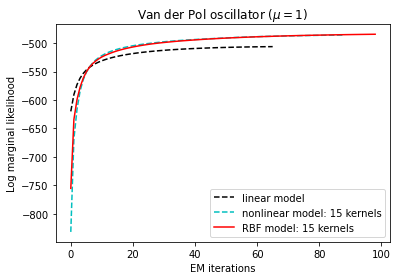

In [25]:
def plot_logmarginal_likelihood():
    plt.plot(ssm_em_lin.llk_list[1:],'k--')
    plt.plot(ssm_emd.llk_list[1:],'c--')
    plt.plot(ssm_rbf.llk_list[1:],'r')
    plt.xlabel('EM iterations')
    plt.ylabel('Log marginal likelihood')
    plt.legend(['linear model','nonlinear model: %i kernels' %Dk, 'RBF model: %i kernels' %Dk_rbf])
    plt.title(r'Van der Pol oscillator ($\mu=%i$)' %mu_param)

plot_logmarginal_likelihood()
plt.savefig('fig/vanderpol_likelihood.pdf', format='pdf')
plt.show()

## RBF model: prediction

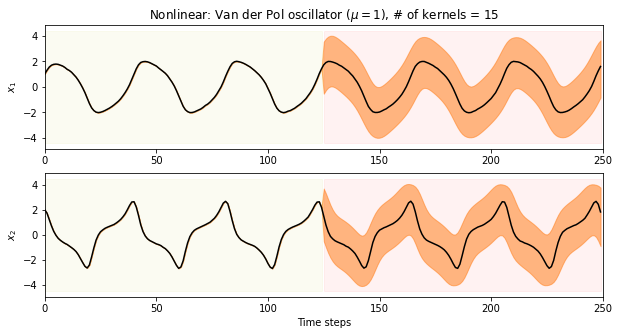

In [26]:
X_test0 = numpy.copy(X[:250,:])
idx_pred = range(int(X_test0.shape[0]*2/4),int(X_test0.shape[0]))
X_test = numpy.copy(X_test0)
X_test[idx_pred,:] = numpy.nan
filter_test, mu, std = ssm_rbf.predict_nans(jnp.array(X_test), smoothed=False)

def plot_prediction_nonlinear(ax_list):
    for ix in range(Dx):
        ax = ax_list[ix]#plt.subplot(Dx,1,ix+1)
        # Title
        if ix == 0:
            ax.set_title(r'Nonlinear: Van der Pol oscillator ($\mu=%i$)' %mu_param + ', # of kernels = %i' %Dk)  
        # Draw the credible intervals of prediction
        x_min = mu[:,ix] - 1.96 * std[:,ix]
        x_max = mu[:,ix] + 1.96 * std[:,ix]
        ax.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
        # Draw filtering, prediction background
        ymin, ymax = ax.get_ylim()
        ax.fill_between(range(0,idx_pred[1]-1), ymin, ymax, color='y', alpha=.05)
        ax.fill_between(idx_pred, ymin, ymax, color='r', alpha=.05)
        # Draw the data
        ax.plot(X_test0[:,ix],'k')
        # Labels
        ax.set_ylabel(r'$x_%d$' %(ix+1))
        ax.set_xlim([0,X_test0.shape[0]])

    ax.set_xlabel('Time steps')
        
fig = plt.figure(figsize=(10,5)) 
ax_list = [fig.add_subplot(Dx,1,1), fig.add_subplot(Dx,1,2)]
plot_prediction_nonlinear(ax_list)
plt.show()